In [57]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda, ToTensor
from torchvision.transforms import v2
from torch.nn import functional as F
from scipy import io as sio

torch.manual_seed(1)

In [58]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datasets

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
I also want to perform 6 transformations for every image as this will reduce the overfitting of the model as well as giving me a training dataset closer to the test dataset.

### Downloading and splitting the dataset

In [59]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        ToTensor()
    ])
)

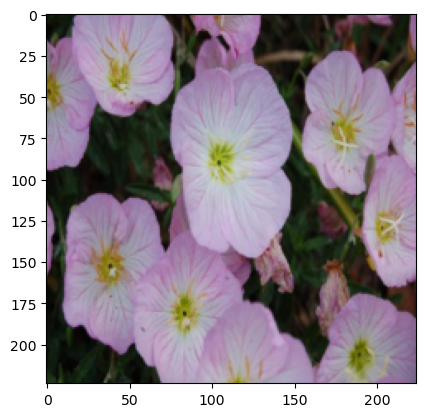

In [60]:
image, label = train_dataset[0]
plt.imshow(image.permute(1,2,0))

In [61]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,generator=torch.Generator(device='cuda'))
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        for image in images:
            mean += image.mean(axis=(1, 2))
            std += image.std(axis=(1, 2))

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    return mean, std
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean} +/- {std}")

Mean: tensor([0.4330, 0.3819, 0.2964]) +/- tensor([0.2588, 0.2094, 0.2212])


In [56]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # These are the values I have calculated
    transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

NameError: name 'v2' is not defined

In [54]:
train_dataset.tr

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cpu


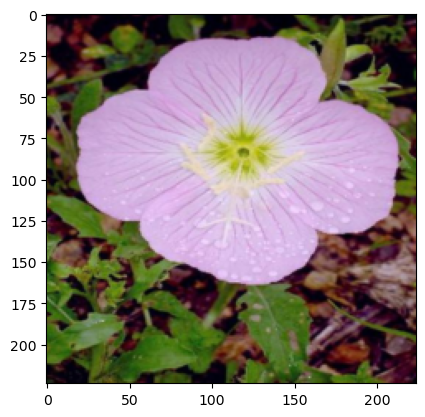

In [55]:
image, label = train_dataset[8]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))